In [2]:
#---import libraries relating to data manipulation, visualization---------------------------------------------------
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json

#-------import libraries to evaluate the deep learning model---------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix, f1_score


import warnings
warnings.filterwarnings('ignore')

#------ import Deep Learning Libraries-------#

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import pickle


pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

import sys
sys.path.append('../../src')  # Add the 'src' directory to the path

#### Import Data Loading and Processing Functions<
from multimodal.helper_functions import  reproducible_comp, get_final_df, force_curve_reshape, acc_curves_reshape
from multimodal.model_architecture import MultimodalModel

reproducible_comp()

In [4]:
file_path = "../../data/processed_data/force_inner.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_force_inner, category_force_inner, category_names, df_force_inner = get_final_df(data, is_acc_data=0, is_multilabel=1)

file_path = "../../data/processed_data/acc_inner.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_acc_inner, category_acc_inner, category_names, df_acc_inner = get_final_df(data, is_acc_data=1, is_multilabel=1)

In [5]:
file_path = "../../data/processed_data/force_outer.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_force_outer, category_force_outer, category_names, df_force_outer = get_final_df(data, is_acc_data=0, is_multilabel=1)

file_path = "../../data/processed_data/acc_outer.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_acc_outer, category_acc_outer, category_names, df_acc_outer = get_final_df(data, is_acc_data=1, is_multilabel=1)

In [6]:
merged_features_force = np.concatenate((features_force_inner,features_force_outer), axis=0)
merged_category_force = np.concatenate((category_force_inner,category_force_outer), axis=0)

merged_features_acc = np.concatenate((features_acc_inner,features_acc_outer), axis=0)
merged_category_acc = np.concatenate((category_acc_inner,category_acc_outer), axis=0)

In [7]:
labels_force = merged_category_force.copy()
features_force = merged_features_force.copy()
feat_force = force_curve_reshape(features_force)
print("Force Features Shape: ", feat_force.shape)
print("Force Labels Shape: ", labels_force.shape)

labels_acc = merged_category_acc.copy()
features_acc = merged_features_acc.copy()
feat_acc = acc_curves_reshape(features_acc)
print("Acceleration Features Shape: ", feat_acc.shape)
print("Acceleration Labels Shape: ", labels_acc.shape)

Force Features Shape:  (2680, 150)
Force Labels Shape:  (2680, 4)
Acceleration Features Shape:  (2680, 1500)
Acceleration Labels Shape:  (2680, 4)


In [8]:
X_train_force, X_test_force, y_train_force, y_test_force = train_test_split(feat_force, labels_force, test_size=0.1, 
                                                    random_state=2, shuffle=True, stratify=labels_force)

X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(feat_acc, labels_acc, test_size=0.1, 
                                                    random_state=2, shuffle=True, stratify=labels_acc)                                                   

In [9]:
X_train_force = X_train_force.reshape(-1, 1, feat_force.shape[1])
X_test_force = X_test_force.reshape(-1, 1, feat_force.shape[1])

X_train_acc = X_train_acc.reshape(-1, 1, feat_acc.shape[1])
X_test_acc = X_test_acc.reshape(-1, 1, feat_acc.shape[1])

print(X_train_force.shape)
print(y_train_force.shape)
print(X_test_force.shape)
print(y_test_acc.shape)

print(X_train_acc.shape)
print(y_train_acc.shape)
print(X_test_acc.shape)
print(y_test_acc.shape)

(2412, 1, 150)
(2412, 4)
(268, 1, 150)
(268, 4)
(2412, 1, 1500)
(2412, 4)
(268, 1, 1500)
(268, 4)


In [10]:
# Specify the path where you want to save the JSON file
config_file_path = "../../02_Optuna_Runs/multimodal/best_configs/multimodal_merged_best_configs.json"

# Load the saved configuration
with open(config_file_path, "r") as config_file:
    best_configs = json.load(config_file)

best_params = best_configs["best_params"]

input_channels = 1
num_classes = 4
force_n_layers = best_params["force_n_layers"]
force_kernel_size = best_params["force_kernel_size"]
force_stride = best_params["force_stride"]
force_padding = best_params["force_padding"]
force_hidden_channels = best_params["force_hidden_channels"]
force_pooling_type = best_params["force_pooling_type"]
force_use_batch_norm = best_params["force_use_batch_norm"]
acc_n_layers = best_params["acc_n_layers"]
acc_kernel_size = best_params["acc_kernel_size"]
acc_stride = best_params["acc_stride"]
acc_padding = best_params["acc_padding"]
acc_hidden_channels = best_params["acc_hidden_channels"]
acc_pooling_type = best_params["force_stride"]
acc_use_batch_norm = best_params["acc_use_batch_norm"]
dropout_prob = best_params["dropout_prob"]
lr = best_params["lr"]

best_params_json = json.dumps(best_params, indent=4)
print(best_params_json)

{
    "lr": 0.0009110549600440013,
    "dropout_prob": 0.26644130402468813,
    "force_n_layers": 6,
    "force_kernel_size": 8,
    "force_stride": 4,
    "force_padding": 6,
    "force_hidden_channels": 225,
    "force_pooling_type": "avg",
    "force_use_batch_norm": true,
    "acc_n_layers": 4,
    "acc_kernel_size": 6,
    "acc_stride": 3,
    "acc_padding": 7,
    "acc_hidden_channels": 74,
    "acc_pooling_type": "avg",
    "acc_use_batch_norm": false
}


# Training Loop with MultilabelStratifiedKFold Cross validation

In [11]:
from torch.utils.data import DataLoader, TensorDataset

def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy

# Convert your data to PyTorch tensors
x_train_force = torch.tensor(X_train_force, dtype=torch.float32)
y_train_force = torch.tensor(y_train_force, dtype=torch.float32)

x_train_acc = torch.tensor(X_train_acc, dtype=torch.float32)
y_train_acc = torch.tensor(y_train_acc, dtype=torch.float32)

x_test_force = torch.tensor(X_test_force, dtype=torch.float32)
y_test_force = torch.tensor(y_test_force, dtype=torch.long)

x_test_acc = torch.tensor(X_test_acc, dtype=torch.float32)
y_test_acc = torch.tensor(y_test_acc, dtype=torch.long)

# Define the number of folds
num_folds = 5

# Initialize KFold cross-validation
mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)

# Define your loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lists to store training and validation loss values for each fold
train_losses = []
valid_losses = []

num_epochs = 50

for fold, (train_indices, valid_indices) in enumerate(mskf.split(x_train_force, y_train_force)):

    train_losses_fold = []  # Store training losses for this fold
    valid_losses_fold = []  # Store validation losses for this fold

    # Split the data into training and validation sets for this fold
    x_fold_train_force = x_train_force[train_indices]
    y_fold_train_force = y_train_force[train_indices]
    x_fold_valid_force = x_train_force[valid_indices]
    y_fold_valid_force = y_train_force[valid_indices]

    x_fold_train_acc = x_train_acc[train_indices]
    y_fold_train_acc = y_train_acc[train_indices]
    x_fold_valid_acc = x_train_acc[valid_indices]
    y_fold_valid_acc = y_train_acc[valid_indices]

    train_dataset_force = TensorDataset(x_fold_train_force, y_fold_train_force)
    valid_dataset_force = TensorDataset(x_fold_valid_force, y_fold_valid_force)

    train_dataset_acc = TensorDataset(x_fold_train_acc, y_fold_train_acc)
    valid_dataset_acc = TensorDataset(x_fold_valid_acc, y_fold_valid_acc)

    train_loader_force = DataLoader(train_dataset_force, batch_size=64, shuffle=True)
    valid_loader_force = DataLoader(valid_dataset_force, batch_size=64, shuffle=False)

    train_loader_acc = DataLoader(train_dataset_acc, batch_size=64, shuffle=True)
    valid_loader_acc = DataLoader(valid_dataset_acc, batch_size=64, shuffle=False)


    model = MultimodalModel(input_channels, num_classes, 
                 force_n_layers, force_kernel_size, force_stride, force_padding, force_hidden_channels,
                 force_pooling_type, force_use_batch_norm,
                 acc_n_layers, acc_kernel_size, acc_stride, acc_padding, acc_hidden_channels,
                 acc_pooling_type, acc_use_batch_norm, dropout_prob).to(device)
    
    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])


    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for (inputs_acc, labels), (inputs_force,lab) in zip(train_loader_acc, train_loader_force):
            inputs_acc, labels, inputs_force = inputs_acc.to(device), labels.to(device), inputs_force.to(device)

            optimizer.zero_grad()

            # Forward pass through the multimodal model
            outputs = model(inputs_force,inputs_acc)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses_fold.append(running_loss / len(train_loader_acc))
        
        # Validation loss calculation (similar to training loop)
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for (inputs_acc_valid, labels_valid), (inputs_force_valid,lab) in zip(valid_loader_acc, valid_loader_force):
                inputs_acc_valid, labels_valid, inputs_force_valid = inputs_acc_valid.to(device), labels_valid.to(device), inputs_force_valid.to(device)
                outputs_valid = model(inputs_force_valid, inputs_acc_valid)
                loss_valid = criterion(outputs_valid, labels_valid.float())
                valid_loss += loss_valid.item()

        valid_losses_fold.append(valid_loss / len(valid_loader_acc))

        if (epoch + 1) % 10 == 0:
            print(f"Fold {fold + 1}, Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader_acc)}, Validation Loss: {valid_loss / len(valid_loader_acc)}")


    train_losses.append(train_losses_fold)
    valid_losses.append(valid_losses_fold)

    # Evaluation on the validation set for this fold
    model.eval()
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for (inputs_acc_valid, labels_valid), (inputs_force_valid,lab) in zip(valid_loader_acc, valid_loader_force):
            inputs_acc_valid, labels_valid, inputs_force_valid = inputs_acc_valid.to(device), labels_valid.to(device), inputs_force_valid.to(device)
            labels_valid = labels_valid.int()
            outputs_valid = model(inputs_force_valid, inputs_acc_valid)
            predicted = (outputs_valid > 0).int()
            y_true_valid.append(labels_valid.cpu().numpy())
            y_pred_valid.append(predicted.cpu().numpy())

    # Convert lists to NumPy arrays for calculations
    y_true_valid = np.array(y_true_valid[0]).reshape(-1,4)
    y_pred_valid = np.array(y_pred_valid[0]).reshape(-1,4)

    accuracy = multi_label_accuracy(y_true_valid, y_pred_valid)
    print(f"Multi-label Validation Accuracy: {accuracy * 100:.2f}%")


Fold 1, Epoch 10/50, Training Loss: 0.3518840103380142, Validation Loss: 0.38384081423282623
Fold 1, Epoch 20/50, Training Loss: 0.29556368675924116, Validation Loss: 0.36424534395337105
Fold 1, Epoch 30/50, Training Loss: 0.26489104090198395, Validation Loss: 0.3985590711236
Fold 1, Epoch 40/50, Training Loss: 0.2386914409937397, Validation Loss: 0.3809865526854992
Fold 1, Epoch 50/50, Training Loss: 0.21842868385776396, Validation Loss: 0.3990744575858116
Multi-label Validation Accuracy: 80.86%
Fold 2, Epoch 10/50, Training Loss: 0.3694039160205472, Validation Loss: 0.42890389636158943
Fold 2, Epoch 20/50, Training Loss: 0.2964721062491017, Validation Loss: 0.5078103803098202
Fold 2, Epoch 30/50, Training Loss: 0.26324700876589746, Validation Loss: 0.5879512317478657
Fold 2, Epoch 40/50, Training Loss: 0.22843098832714942, Validation Loss: 0.6410092487931252
Fold 2, Epoch 50/50, Training Loss: 0.2013469612406146, Validation Loss: 0.7097072005271912
Multi-label Validation Accuracy: 85

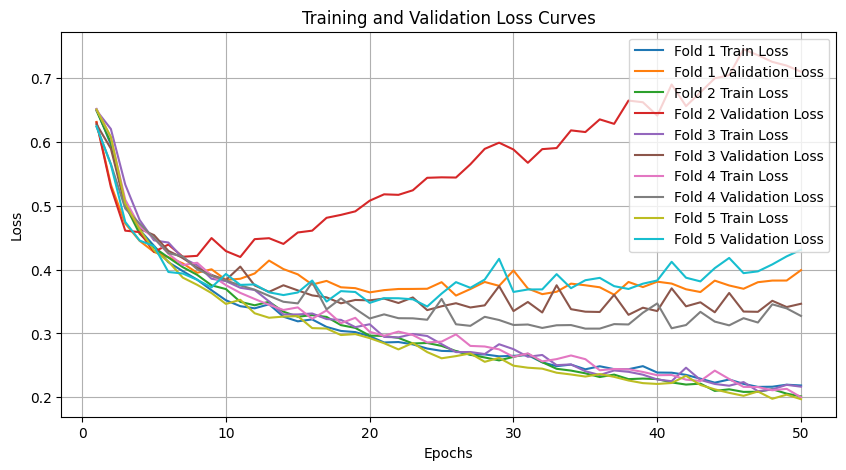

In [12]:
plt.figure(figsize=(10, 5))

# Plot training and validation loss curves for each fold
for fold in range(num_folds):
    plt.plot(range(1, num_epochs + 1), train_losses[fold], label=f'Fold {fold + 1} Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses[fold], label=f'Fold {fold + 1} Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
torch.save(model, '../../artifacts/multimodal_merged_supervised.pth')

# Evaluation on Test Data

In [14]:
# Evaluation on test set
model = torch.load('../../artifacts/multimodal_merged_supervised.pth')


Multi-label Accuracy: 84.42%
Multi-label F1-Score: 77.35%
Classification Report:
               precision    recall  f1-score   support

        Dünn       0.85      0.97      0.90       103
    Referenz       0.82      0.91      0.86        54
        Slug       0.76      0.57      0.65       109
        Worn       0.74      0.63      0.68       106

   micro avg       0.79      0.75      0.77       372
   macro avg       0.79      0.77      0.77       372
weighted avg       0.78      0.75      0.76       372
 samples avg       0.78      0.76      0.75       372



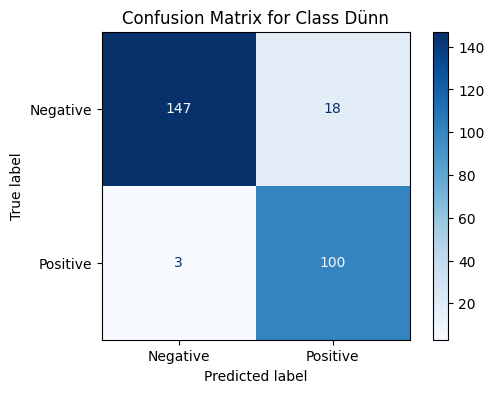

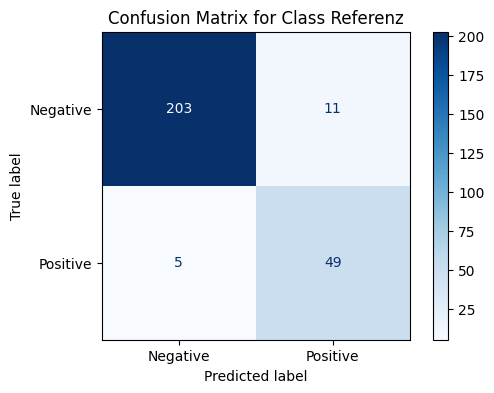

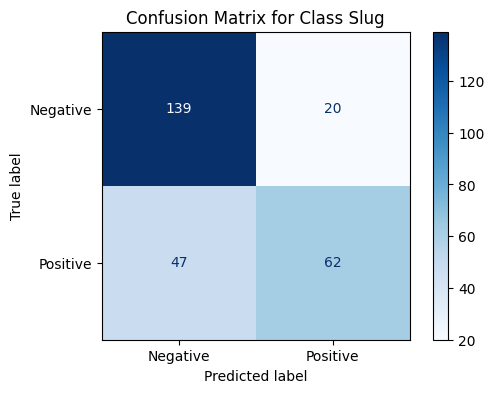

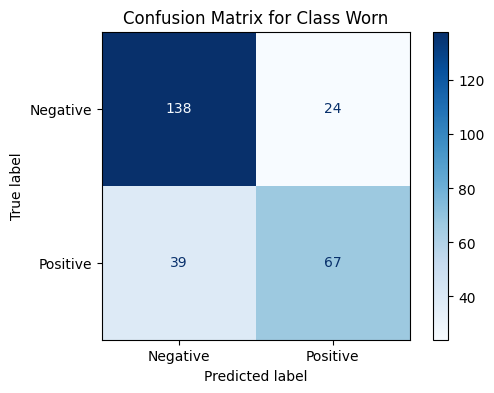

In [15]:
# Evaluation on test set
model.eval()
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for inputs_force_test, inputs_acc_test, labels_test in zip(x_test_force,x_test_acc, y_test_force):
        inputs_force_test, inputs_acc_test, labels_test = inputs_force_test.to(device), inputs_acc_test.to(device), labels_test.to(device)
        
        labels_test = labels_test.int()
        
        outputs = model(inputs_force_test.unsqueeze(0), inputs_acc_test.unsqueeze(0)) 
        predicted = (outputs > 0).int() 
        
        y_true_test.append(labels_test.cpu().numpy())
        y_pred_test.append(predicted.cpu().numpy())

# Convert lists to NumPy arrays for calculations
y_true_test = np.array(y_true_test).reshape(-1,4)
y_pred_test = np.array(y_pred_test).reshape(-1,4)


accuracy = multi_label_accuracy(y_true_test, y_pred_test)
print(f"Multi-label Accuracy: {accuracy * 100:.2f}%")

f1 = f1_score(y_true_test, y_pred_test, average='macro')
print(f"Multi-label F1-Score: {f1 * 100:.2f}%")

# Generate a classification report
report = classification_report(y_true_test, y_pred_test, target_names=category_names)
print("Classification Report:\n", report)

# Compute the multi-label confusion matrix
conf_matrix = multilabel_confusion_matrix(y_true_test, y_pred_test)

# Visualize each confusion matrix with sample counts
for i, matrix in enumerate(conf_matrix):
    total_samples = matrix.sum()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Negative", "Positive"])
    fig, ax = plt.subplots(figsize=(6, 4))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
    ax.set_title(f'Confusion Matrix for Class {category_names[i]}')
    
    plt.show()

In [16]:
print(summary(model, [(1, 150), (1, 1500)]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 225, 39]           2,025
              ReLU-2              [-1, 225, 39]               0
         AvgPool1d-3              [-1, 225, 19]               0
       BatchNorm1d-4              [-1, 225, 19]             450
            Conv1d-5               [-1, 225, 6]         405,225
              ReLU-6               [-1, 225, 6]               0
         AvgPool1d-7               [-1, 225, 3]               0
       BatchNorm1d-8               [-1, 225, 3]             450
            Conv1d-9               [-1, 225, 2]         405,225
             ReLU-10               [-1, 225, 2]               0
        AvgPool1d-11               [-1, 225, 1]               0
      BatchNorm1d-12               [-1, 225, 1]             450
           Conv1d-13               [-1, 225, 2]         405,225
             ReLU-14               [-1,

# Thank You